In [7]:
import Bio.SeqIO

In [8]:
dir(Bio)

['Align',
 'AlignIO',
 'Alphabet',
 'BiopythonDeprecationWarning',
 'BiopythonExperimentalWarning',
 'BiopythonParserWarning',
 'BiopythonWarning',
 'Data',
 'File',
 'GenBank',
 'MissingExternalDependencyError',
 'MissingPythonDependencyError',
 'Nexus',
 'Seq',
 'SeqFeature',
 'SeqIO',
 'SeqRecord',
 'Sequencing',
 'SwissProt',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_py3k']

In [66]:
with open("../data/hg38.gb") as handle:
    for record in Bio.SeqIO.parse(handle, 'genbank'):
        print("record:", record.id)
        #print("dir:", dir(record))

record: NC_000017.11


In [79]:
%%bash
wget -O /tmp/assembly.txt ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/405/GCF_000001405.33_GRCh38.p7/GCF_000001405.33_GRCh38.p7_assembly_report.txt
cat /tmp/assembly.txt | grep "^#" | tail -n 1 > /tmp/assembly_headers.txt
cat /tmp/assembly.txt | grep -v "^#" > /tmp/assembly_processed.txt


--2018-01-03 10:22:32--  ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/405/GCF_000001405.33_GRCh38.p7/GCF_000001405.33_GRCh38.p7_assembly_report.txt
           => ‘/tmp/assembly.txt’
Resolving ftp.ncbi.nlm.nih.gov... 130.14.250.12, 2607:f220:41e:250::11
Connecting to ftp.ncbi.nlm.nih.gov|130.14.250.12|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /genomes/all/GCF/000/001/405/GCF_000001405.33_GRCh38.p7 ... done.
==> SIZE GCF_000001405.33_GRCh38.p7_assembly_report.txt ... 60131
==> PASV ... done.    ==> RETR GCF_000001405.33_GRCh38.p7_assembly_report.txt ... done.
Length: 60131 (59K) (unauthoritative)

     0K .......... .......... .......... .......... .......... 85% 1.56M 0s
    50K ........                                              100% 10.4M=0.03s

2018-01-03 10:22:32 (1.79 MB/s) - ‘/tmp/assembly.txt’ saved [60131]



In [81]:
with open('/tmp/assembly_headers.txt', 'r') as f:
    headers = f.readlines()[0].strip().split()[1:]
    print(headers)

['Sequence-Name', 'Sequence-Role', 'Assigned-Molecule', 'Assigned-Molecule-Location/Type', 'GenBank-Accn', 'Relationship', 'RefSeq-Accn', 'Assembly-Unit', 'Sequence-Length', 'UCSC-style-name']


In [65]:
genes = []

def parse_location(location_str):
    return location_str.split('..')

def parse_string(location_str):
    if location_str.index('complement') == 0:
        return '-'
    else:
        return '+'

count = 0
genes = {}
ncRNAs = []

def parse_entity(feature):
    '''
    Parse a transcribed entity
    '''
    entity = {}
    # print('feature:', feature)
    
    entity['start'] = feature.location.start.position
    entity['end'] = feature.location.end.position
    entity['strand'] = '+' if feature.location.strand == 1 else '-'
    #print(dir(feature))
    #print("qulaifiers:", feature.qualifiers)
    if 'gene' in feature.qualifiers:
        entity['name'] = feature.qualifiers['gene'][0]
    
    
    for part in feature.location.parts:
        entity['location_parts'] = {
            'start': part.start.position,
            'end': part.end.position,
            'strand': '+' if part.strand == 1 else '-',
        }

    for xref in feature.qualifiers['db_xref']:
        parts = xref.split(':')
        if parts[0] == 'GeneID':
            entity['geneId'] = parts[1]
            break

    if 'transcript_id' in feature.qualifiers:
        entity['transcriptId'] = feature.qualifiers['transcript_id'][0]

    #print('entity:', entity)
    return entity

for feature in record.features:
    # print("dir", dir(feature))
    # print(feature.type)
    # print(feature.location, type(feature.location))
    # print(dir(feature))
    curr_entity = parse_entity(feature)
    curr_entity['type'] = feature.type
    
    if feature.type == 'gene':
        curr_entity['mRNAs'] = []
        genes[curr_entity['geneId']] = curr_entity
        
        if 'pseudo' in feature.qualifiers:
            curr_entity['type'] = 'pseudo'
        
        # print("gene", curr_entity)
    elif feature.type == 'CDS':
        #print("feature:", feature)

        cds = {}
        cds['start'] = feature.location.start.position
        cds['end'] = feature.location.end.position
        genes[curr_entity['geneId']]['cds'] = cds
    elif feature.type == 'ncRNA':
        genes[curr_entity['geneId']] = curr_entity
    elif feature.type == 'mRNA':
        if 'mRNAs' not in genes[curr_entity['geneId']]:
            genes[curr_entity['geneId']]['mRNAs'] = []
        genes[curr_entity['geneId']]['mRNAs'] += [curr_entity]
    elif feature.type == 'misc_RNA':
        genes[curr_entity['geneId']] = curr_entity        
        #print(feature)
    elif feature.type == 'precursor_RNA':
        genes[curr_entity['geneId']] = curr_entity
    elif feature.type == 'tRNA':
        genes[curr_entity['geneId']] = curr_entity
    else:
        print(feature)
        
    count += 1

import json
with open('/tmp/out.json', 'w') as f:
    json.dump(genes, f, indent=2)
print("count:", count)

type: source
location: [0:83257441](+)
qualifiers:
    Key: chromosome, Value: ['17']
    Key: db_xref, Value: ['taxon:9606']
    Key: mol_type, Value: ['genomic DNA']
    Key: organism, Value: ['Homo sapiens']

count: 16605


Bio.__version__

In [12]:
dir(feature)

['__bool__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_flip',
 '_get_location_operator',
 '_get_ref',
 '_get_ref_db',
 '_get_strand',
 '_set_location_operator',
 '_set_ref',
 '_set_ref_db',
 '_set_strand',
 '_shift',
 'extract',
 'id',
 'location',
 'location_operator',
 'qualifiers',
 'ref',
 'ref_db',
 'strand',
 'type']

In [70]:
a = [25, 33, 47, 53, 62, 64, 78, 86, 99, 144, 164, 217, 219, 222, 240, 257, 356]

In [75]:
%matplotlib inline

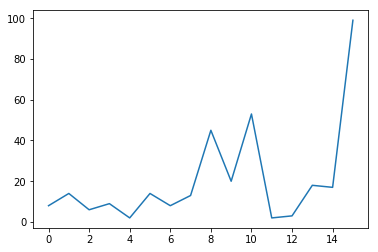

In [77]:
import matplotlib.pyplot as plt

plt.plot(range(len(a)-1), [a[i+1] - a[i] for i in range(len(a)-1)])